### **Setting Up the Project Path for Imports**

In [1]:
import os
import sys
print(os.getcwd())
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../")) 
sys.path.append(project_root)  # Ensure src/ is found

d:\HCMUT\HK242\ML\ML_capybara\src\models\EnsembleLearning


### Boosting Model

In [2]:
from scipy import sparse
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np

class MulticlassGradientBoosting:
    def __init__(self, n_estimators=10, learning_rate=1.0, max_depth=1, random_state=None):
        self.n_estimators   = n_estimators
        self.learning_rate  = learning_rate
        self.max_depth      = max_depth
        self.random_state   = random_state

    def _one_hot(self, y):
        classes = np.unique(y)
        y_ohe = np.zeros((len(y), len(classes)))
        for i, cls in enumerate(classes):
            y_ohe[:, i] = (y == cls).astype(float)
        return y_ohe, np.sort(classes)

    def _softmax(self, F):
        ex = np.exp(F - F.max(axis=1, keepdims=True))
        return ex / ex.sum(axis=1, keepdims=True)


    def fit(self, X, y, X_val=None, y_val=None):
        if sparse.issparse(X):
            X = X.toarray()
        else:
            X = np.asarray(X)
        y = np.asarray(y)

        if X_val is not None:
            if sparse.issparse(X_val):
                X_val = X_val.toarray()
            else:
                X_val = np.asarray(X_val)
            y_val = np.asarray(y_val)


        y_ohe, classes = self._one_hot(y)
        self.classes_ = classes          
        n, K = y_ohe.shape


        F = np.zeros((n, K))              # training logits
        if X_val is not None:
            F_val = np.zeros((X_val.shape[0], K))


        self.trees        = [[None]*K for _ in range(self.n_estimators)]
        self.leaf_values  = [[{} for _ in range(K)] for _ in range(self.n_estimators)]
        self.train_score_ = []
        self.val_score_   = []

        # =================== Boosting ====================================
        for m in range(self.n_estimators):

            P = self._softmax(F)          # (n, K)
            R = y_ohe - P                 # residual

            for k in range(K):
                # Residual of class k
                res_k = R[:, k]              # (n,)

                # Use regression because we are working with rediual not labels
                tree = DecisionTreeRegressor(
                    max_depth     = self.max_depth,
                    random_state  = self.random_state
                )
                tree.fit(X, res_k) 
                self.trees[m][k] = tree

                leaf_ids      = tree.apply(X) # (n,)
                if X_val is not None:
                    leaf_ids_val = tree.apply(X_val)

                for leaf in np.unique(leaf_ids):
                    idx = leaf_ids == leaf  # Create a mask to find the residual rows corresponding the the leaf
                    v   = res_k[idx].mean() * self.learning_rate
                    self.leaf_values[m][k][leaf] = v

                    # Nudging the prediction
                    F[idx, k] += v
                    if X_val is not None:
                        idx_val = leaf_ids_val == leaf
                        F_val[idx_val, k] += v

            # track accuracy
            y_train_pred = self.classes_[np.argmax(self._softmax(F), axis=1)]
            self.train_score_.append((y_train_pred == y).mean())

            if X_val is not None:
                y_val_pred = self.classes_[np.argmax(self._softmax(F_val), axis=1)]
                self.val_score_.append((y_val_pred == y_val).mean())


    def predict_proba(self, X):
        # Sometimes saving spaces in one place means a couple extra lines of code in
        if sparse.issparse(X):
            X = X.toarray()
        else:
            X = np.array(X)
        n = X.shape[0]
        F = np.zeros((n, len(self.classes_)))
        for m in range(self.n_estimators):
            for k in range(len(self.classes_)):
                tree = self.trees[m][k]
                vals = self.leaf_values[m][k] #  dict {leaf_ID : v}
                leaf_ids = tree.apply(X) # (n, )
                for leaf, v in vals.items():
                    F[leaf_ids==leaf, k] += v
        return self._softmax(F)

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]


In [3]:
from src.data.preprocess import Preprocessing
from src.data.feature_extraction import FeatureExtraction

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble             import BaggingClassifier
from sklearn.tree                 import DecisionTreeClassifier
from sklearn.model_selection      import train_test_split
from sklearn.metrics             import (
    accuracy_score, confusion_matrix,
    classification_report, f1_score,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing        import label_binarize
import matplotlib.pyplot as plt

### **Loading Dataset and Preprocessing**


In [4]:
pre = Preprocessing()
fe = FeatureExtraction(seed=3)

df  = pre.read_CSV('train.csv')
df['processed_text'] = df['text'].map(
    lambda t: " ".join(pre.preprocess(t, return_tokens=True))
)


X_tfidf = fe.tfidf_vectorize(
    df['processed_text'],
    max_gram=3,
    max_features=50000
)  


X_train, X_val, y_train, y_val = fe.split_dataset(
    X_tfidf,
    df['sentiment'],
    ratio=0.9
)



### **Fitting the Gradient Boosting Decision Tree Model**

In [ ]:
model = MulticlassGradientBoosting(
    n_estimators=10,
    learning_rate=1,
    max_depth=3,
    random_state=2025
)
model.fit(X_train, y_train, X_val=X_val, y_val=y_val)



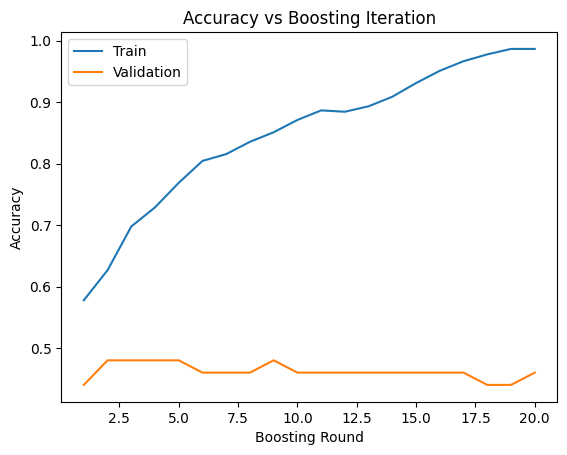

In [ ]:
rounds = range(1, model.n_estimators+1)
plt.plot(rounds, model.train_score_, label='Train')
plt.plot(rounds, model.val_score_,   label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Boosting Iteration')
plt.legend()
plt.show()

### **Evaluating the Gradient Boosting Decision Tree Model**

Computes metrics: **F1-score, and a confusion matrix** to evaluate the model.


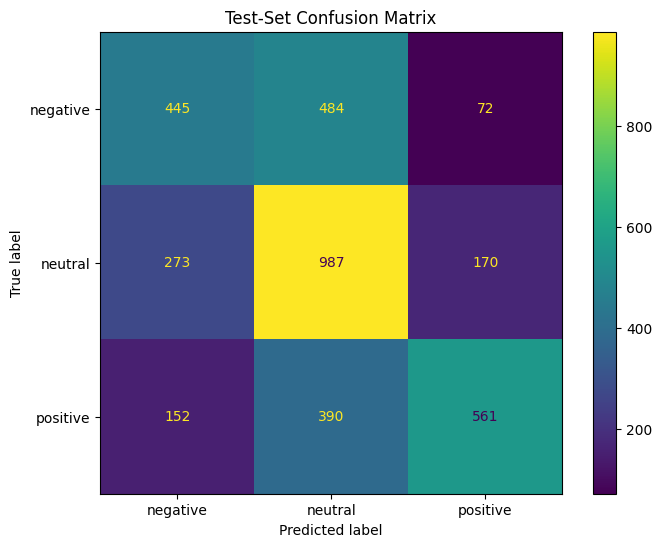

F1 score (weighted): 0.5612
Accuracy: 0.5640


In [ ]:
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score, ConfusionMatrixDisplay

val_df  = pre.read_CSV('test.csv')
val_df['processed_text'] = val_df['text'].map(
    lambda t: " ".join(pre.preprocess(t, return_tokens=True))
)

y_test = val_df['sentiment'].values

X_test_tfidf  = fe.tfidf_transform(val_df['processed_text'])
y_pred    = model.predict(X_test_tfidf)       
probs_test = model.predict_proba(X_test_tfidf) 


cm = confusion_matrix(y_test, y_pred, labels=model.classes_)


disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model.classes_
)


fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)              
ax.set_title('Test-Set Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 score (weighted): {f1:.4f}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
